In [1]:
import numpy as np
from numpy import random
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.optimize import curve_fit
from sympy.solvers import solve
from sympy import Symbol


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
def input_set_up(spectro, ms): 
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

def func1(x, a, b, c):
    return(-b/(2*a)*(x**2) + b * x + c)

def inv_func1(y, a, b, c):
    x1 = a + (-a*(math.sqrt(abs(b**2 + 2*b*(c-y)/a))/b))
    x2 = a - (-a*(math.sqrt(abs(b**2 + 2*b*(c-y)/a))/b))
    #print(x1, x2)
    if(a>=0):
        return(x1)
    else:
        return(x2)

def inv_func2(y, a, b, c, dx):
    x1 = (-b + (math.sqrt(abs(b**2 - 4*a*(c-y)))))/(2*a)
    x2 = (-b - (math.sqrt(abs(b**2 - 4*a*(c-y)))))/(2*a)
    #print(x1, x2)
    if(dx):
        return(x2)
    else:
        return(x1)

In [3]:
angles = 90
angles

90

In [ ]:
for angle in angles:
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°
    tone = 100
    tone_error = 2
    Cm_bushy = 10

    sim_time = 1000

    max_ild = 2
    mean_amplitude = 1000

    ANFs2SBCs_weight = 2.0
    ANFs2GBCs_weight = 1.0
    GBCs2MNTBCs_weight = 16.0

    SBCs2MSO_weight = 4.0
    MNTBCs2MSO_weights = [-2.0, -4.0, -6.0, -8.0, -10.0, -12.0, -14.0, -16.0, -20.0, -24.0]
    n_battery = len(MNTBCs2MSO_weights)
    SBCs2LSO_weight = 16.0
    MNTBCs2LSO_weight = -2.0

    delay = 0.1
    noise_rate = 20
    mean_rate = 0

    n_ANFs = 35000
    ANFs2SBCs = 4
    ANFs2GBCs = 20
    n_SBCs = int(n_ANFs/ANFs2SBCs)
    n_GBCs = int(n_ANFs/ANFs2GBCs)

    freq = np.round(np.logspace(np.log(20),np.log(20000),num = 3500, base = np.exp(1)),2)

    spectro = np.zeros((3500,sim_time))
    channels = len(freq[np.where((freq>tone-tone_error) & (freq<tone+tone_error))])
    amplitudes = stats.norm.pdf(np.linspace(-1, 1, channels) , 0, 1.0/(math.sqrt(2*math.pi)*1))
    spectro[np.where(freq>tone-tone_error)[0][0]:np.where((freq<tone+tone_error))[0][-1]+1, :] = amplitudes.reshape(channels,1)*np.ones((channels, sim_time))

    w_head = 22 #cm
    v_sound = 33000 #cm/s
    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms
    ipds = 2*np.pi*itd*freq/1000
    ild = angle*max_ild/90

    # Populations

    r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                        'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

    r_ANFs = nest.Create('parrot_neuron',n_ANFs)

    r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    r_MSO = nest.Create('iaf_cond_alpha', n_GBCs*n_battery, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                    'phase': 0})

    l_ANFs = nest.Create('parrot_neuron',n_ANFs)

    l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    l_MSO = nest.Create('iaf_cond_alpha', n_GBCs*n_battery, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                     params = {'C_m': Cm_bushy, 'V_m': -70})

    ANFs_noise = nest.Create('poisson_generator',1,
                     params = {'rate':noise_rate})

    s_rec_r = nest.Create('spike_recorder')
    s_rec_l = nest.Create('spike_recorder')

    nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
    nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

    nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
    nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

    nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
    nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

    nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
    nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

    nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
    nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

    nest.Connect(r_MSO, s_rec_r, 'all_to_all')
    nest.Connect(r_LSO, s_rec_r, 'all_to_all')

    nest.Connect(l_MSO, s_rec_l, 'all_to_all')
    nest.Connect(l_LSO, s_rec_l, 'all_to_all')

    for r in range(len(spectro)-1):
        if(np.any(spectro[r][:] > 0)):
            nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
            nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

    for j in range(n_SBCs):
        nest.Connect(r_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], r_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
        nest.Connect(l_ANFs[j*ANFs2SBCs:j*ANFs2SBCs+ANFs2SBCs], l_SBCs[j], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

    for k in range(n_GBCs):
        nest.Connect(r_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], r_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
        nest.Connect(l_ANFs[k*ANFs2GBCs:k*ANFs2GBCs+ANFs2GBCs], l_GBCs[k], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

    for w in range(n_GBCs):
        nest.Connect(r_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_LSO[w], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
        nest.Connect(l_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], l_LSO[w], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})  
        for y in range(n_battery):
            nest.Connect(r_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
            nest.Connect(l_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], r_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
            nest.Connect(r_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], l_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
            nest.Connect(l_SBCs[w*int(ANFs2GBCs/ANFs2SBCs):w*int(ANFs2GBCs/ANFs2SBCs)+int(ANFs2GBCs/ANFs2SBCs)], l_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight}) 

    nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delay})
    nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight,  "delay": delay})

    nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight,  "delay": delay})
    nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight,  "delay": delay})  

    for w in range(n_GBCs):      
        for y in range(n_battery):
            nest.Connect(l_MNTBCs[w], r_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[y],  "delay": delay})
            nest.Connect(r_MNTBCs[w], l_MSO[w*n_battery + y], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[y],  "delay": delay})

    if(angle>=0): 
        mean_amplitude_r = mean_amplitude
        mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
    else:
        mean_amplitude_l = mean_amplitude
        mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))

    for i in range(sim_time):
        input_set_up(spectro,i)
        nest.Simulate(1)

    data_r = s_rec_r.get('events')
    data_l = s_rec_l.get('events')

    id_r_ANF1 = r_ANFs[0].get('global_id')
    id_r_SBC1 = r_SBCs[0].get('global_id')
    id_r_GBC1 = r_GBCs[0].get('global_id')
    id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
    id_r_MSO1 = r_MSO[0].get('global_id')
    id_r_LSO1 = r_LSO[0].get('global_id')
    id_l_ANF1 = l_ANFs[0].get('global_id')
    id_l_SBC1 = l_SBCs[0].get('global_id')
    id_l_GBC1 = l_GBCs[0].get('global_id')
    id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
    id_l_MSO1 = l_MSO[0].get('global_id')
    id_l_LSO1 = l_LSO[0].get('global_id')

    #Value of LSO spikes
    r_LSO_rate = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])
    l_LSO_rate = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])
    
    #Binay info of LSO spikes
    if(r_LSO_rate>=l_LSO_rate):
        dx = 1
    else:
        dx = 0
      
    #Value of MSO spikes
    r_MSO_rate = np.zeros(n_battery)
    l_MSO_rate = np.zeros(n_battery)

    for h in range(n_battery):
        if((86321 + h) in np.unique(data_r['senders'])):
            r_MSO_rate[h] = (np.unique(data_r['senders'][np.where(data_r['senders']==86321+h)], return_counts= True)[1][0])
        else:
            r_MSO_rate[h] = 0

        if((86321 - id_r_MSO1 + id_l_MSO1 + h) in np.unique(data_l['senders'])):
            l_MSO_rate[h] = (np.unique(data_l['senders'][np.where(data_l['senders']== 86321 - id_r_MSO1 + id_l_MSO1 + h)], return_counts= True)[1][0])
        else:
            l_MSO_rate[h] = 0


    #PREDICTIONS    
    preds = np.zeros(3+3*7+2)
    R_sq = np.zeros(2+14+1)
    
    # Right LSO
    max_x = 90
    x = np.arange(-90,100,10)
    y = np.loadtxt('data_ILDs_new2/r_s_100_1000',  delimiter=',')
    popt, pcov = curve_fit(func1, x, y, bounds=([max_x, -np.inf, -np.inf], np.inf))
    a, b, c, = popt
    corr_matrix = np.corrcoef(y, func1(x, *popt))
    corr = corr_matrix[0,1]
    R_sq[0] = corr**2
    
    #Prediction
    if(r_LSO_rate>np.max(func1(x, *popt))):
        r_LSO_rate = np.max(func1(x, *popt))
    if(r_LSO_rate<np.min(func1(x, *popt))):
        r_LSO_rate = np.min(func1(x, *popt))
    preds[0] = inv_func1(r_LSO_rate, a, b, c)

    # Left LSO
    min_x = -90
    y = np.loadtxt('data_ILDs_new2/l_s_100_1000',  delimiter=',')
    popt, pcov = curve_fit(func1, x, y, bounds=(-np.inf, [min_x, np.inf, np.inf]))
    a, b, c, = popt
    corr_matrix = np.corrcoef(y, func1(x, *popt))
    corr = corr_matrix[0,1]
    R_sq[1] = corr**2
    #Prediction
    if(l_LSO_rate>np.max(func1(x, *popt))):
        l_LSO_rate = np.max(func1(x, *popt))
    if(l_LSO_rate<np.min(func1(x, *popt))):
        l_LSO_rate = np.min(func1(x, *popt))
    preds[1] = inv_func1(l_LSO_rate, a, b, c)
    
    preds[2] = (preds[1]+preds[0])/2
    
    

    #MSO
    itds = np.arange(-1,1.05,0.05)
    n_battery = 10
    #r_rate_group3 = np.zeros([n_battery, len(itds)])
    #l_rate_group3 = np.zeros([n_battery, len(itds)])
    r_rate_group4 = np.zeros([n_battery, len(itds)])
    l_rate_group4 = np.zeros([n_battery, len(itds)])
    #r_rate_group5 = np.zeros([n_battery, len(itds)])
    #l_rate_group5 = np.zeros([n_battery, len(itds)])

    for n in range(len(itds)):
        #r_rate_group3[:,n] = np.loadtxt('data_ITDs_1000_new_weights/rate_group3_itd_{}'.format(round(itds[n],2)), delimiter=',')
        #l_rate_group3[:,n] = np.loadtxt('data_ITDs_1000_new_weights/left_rate_group3_itd_{}'.format(round(itds[n],2)), delimiter=',')
        r_rate_group4[:,n] = np.loadtxt('data_ITDs_1000_new_weights/rate_group4_itd_{}'.format(round(itds[n],2)), delimiter=',')
        l_rate_group4[:,n] = np.loadtxt('data_ITDs_1000_new_weights/left_rate_group4_itd_{}'.format(round(itds[n],2)), delimiter=',')
        #r_rate_group5[:,n] = np.loadtxt('data_ITDs_1000_new_weights/rate_group5_itd_{}'.format(round(itds[n],2)), delimiter=',')
        #l_rate_group5[:,n] = np.loadtxt('data_ITDs_1000_new_weights/left_rate_group5_itd_{}'.format(round(itds[n],2)), delimiter=',')

    #r_rate_groups = (r_rate_group3 + r_rate_group4 + r_rate_group5)/3
    #l_rate_groups = (l_rate_group3 + l_rate_group4 + l_rate_group5)/3
    
    
    lim = 1000000*(w_head*np.sin(np.deg2rad(90)))/v_sound #us
    x_range = np.arange(-lim, lim + lim/1000, lim/1000)

    for i in range(7):
        x = itds*1000
        #Right MSO
        y = r_rate_group4[i,:]
        coeff = np.polyfit(x, y, 2)
        y_range = coeff[0]*x_range**2 + coeff[1]*x_range + coeff[2]
        corr_matrix = np.corrcoef(y, coeff[0]*x**2 + coeff[1]*x + coeff[2])
        corr = corr_matrix[0,1]
        R_sq_right = corr**2
        
        if(r_MSO_rate[i] == 0):
            #Prediction
            pred_r = np.nan
        else:
            if(r_MSO_rate[i]>np.max(y_range)):
                r_MSO_rate[i]=np.max(y_range)
            if(r_MSO_rate[i]<np.min(y_range)):
                r_MSO_rate[i]=np.min(y_range)
            #Prediction
            pred = inv_func2(r_MSO_rate[i], coeff[0], coeff[1], coeff[2], dx)
            if(pred>=np.max(x_range)):
                pred=np.max(x_range)
            if(pred<np.min(x_range)):
                pred=np.min(x_range)
            pred_r = np.rad2deg(np.arcsin((v_sound*pred)/(1000000*w_head)))
        
        #Left MSO
        y = l_rate_group4[i,:]
        coeff = np.polyfit(x, y, 2)
        y_range = coeff[0]*x_range**2 + coeff[1]*x_range + coeff[2]
        corr_matrix = np.corrcoef(y, coeff[0]*x**2 + coeff[1]*x + coeff[2])
        corr = corr_matrix[0,1]
        R_sq_left = corr**2
       
        if(l_MSO_rate[i] == 0):
            #Prediction
            pred_l = np.nan
        else:
            if(l_MSO_rate[i]>=np.max(y_range)):
                l_MSO_rate[i]=np.max(y_range)
            if(l_MSO_rate[i]<np.min(y_range)):
                l_MSO_rate[i]=np.min(y_range)
            #Prediction
            pred = inv_func2(l_MSO_rate[i], coeff[0], coeff[1], coeff[2], dx)
            if(pred>np.max(x_range)):
                pred=np.max(x_range)
            if(pred<np.min(x_range)):
                pred=np.min(x_range)
            pred_l = np.rad2deg(np.arcsin((v_sound*pred)/(1000000*w_head)))
        
        preds[3 + 3*i] = pred_r
        preds[3 + 3*i + 1] = pred_l
        preds[3 + 3*i + 2] = (pred_r + pred_l)/2
        
        R_sq[2+2*i] = R_sq_right
        R_sq[2+2*i+1] = R_sq_left
    
    preds[-2] = dx
    preds[-1] = angle
    R_sq[-1] = angle
    
    np.savetxt('results_angle_{}'.format(angle), preds)
    np.savetxt('R_sq_angle_{}'.format(angle), R_sq)


Apr 13 15:59:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Apr 13 16:00:31 NodeManager::prepare_nodes [Info]: 
    Preparing 1253048 nodes for simulation.

Apr 13 16:00:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 13 16:00:32 SimulationManager::run [Info]: 
    Simulation finished.

Apr 13 16:00:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253048 nodes for simulation.

Apr 13 16:00:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1253048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 13 16:00:32 SimulationManager::run [Info]: 
    Simulation finished.

Apr 13 16:00:32 NodeManager::prepare_nodes [Info]: 
    Preparing 1253048 nodes for simulation.

Apr 13 16:00:32 SimulationManager::start_updating_ [Info]: 
    Number of l

MSE: 958.516 deg
R_pearson: 0.837
p_value: 0.0


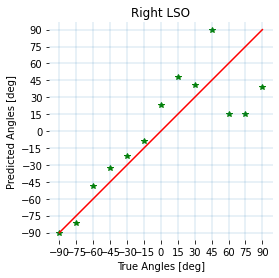

MSE: 992.447 deg
R_pearson: 0.837
p_value: 0.8379360092438674


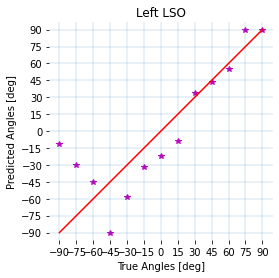

MSE: 372.368 deg
R_pearson: 0.837
p_value: 0.8379360092438674


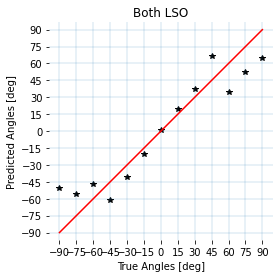

MSE: 391.476 deg
R_pearson: 0.837
p_value: 0.8379360092438674


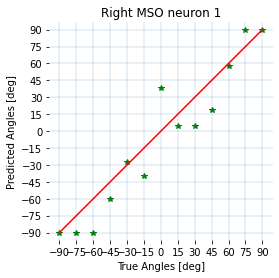

MSE: 425.226 deg
R_pearson: 0.837
p_value: 0.8379360092438674


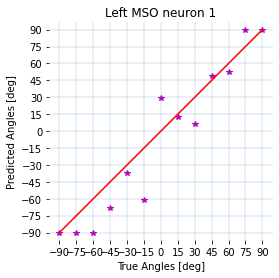

MSE: 376.119 deg
R_pearson: 0.837
p_value: 0.8379360092438674


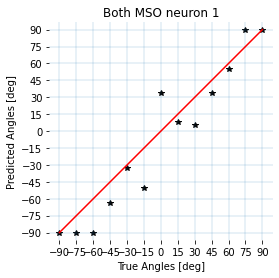

MSE: 635.329 deg
R_pearson: 0.837
p_value: 0.8379360092438674


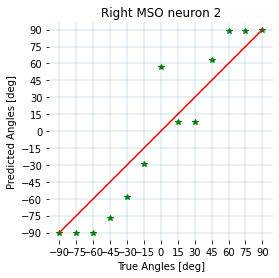

MSE: 597.402 deg
R_pearson: 0.837
p_value: 0.8379360092438674


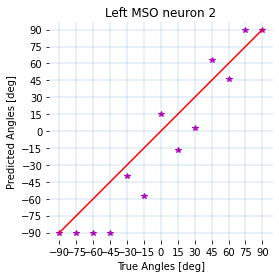

MSE: 509.004 deg
R_pearson: 0.837
p_value: 0.8379360092438674


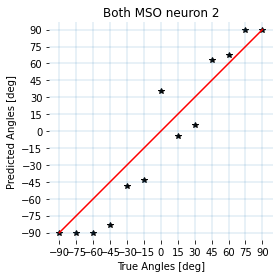

MSE: 809.103 deg
R_pearson: 0.837
p_value: 0.8379360092438674


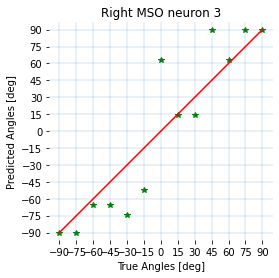

MSE: 1083.267 deg
R_pearson: 0.837
p_value: 0.8379360092438674


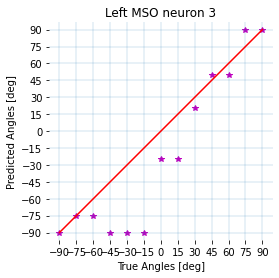

MSE: 684.554 deg
R_pearson: 0.837
p_value: 0.8379360092438674


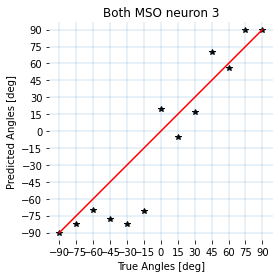

MSE: 1405.337 deg
R_pearson: 0.837
p_value: 0.8379360092438674


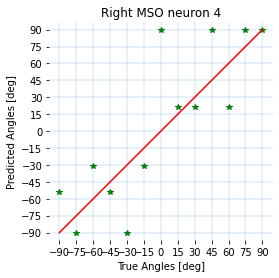

MSE: 1223.115 deg
R_pearson: 0.837
p_value: 0.8379360092438674


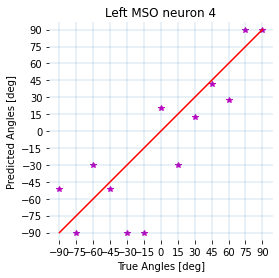

MSE: 1056.087 deg
R_pearson: 0.837
p_value: 0.8379360092438674


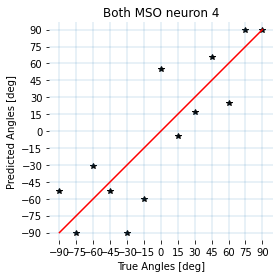

MSE: 1376.306 deg
R_pearson: 0.837
p_value: 0.8379360092438674


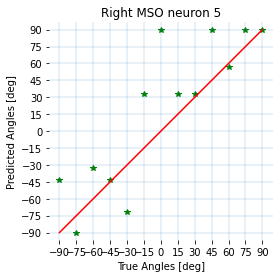

MSE: 1128.554 deg
R_pearson: 0.837
p_value: 0.8379360092438674


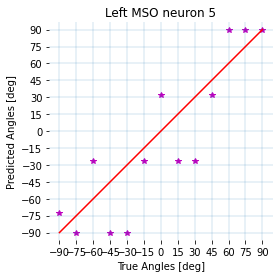

MSE: 834.501 deg
R_pearson: 0.837
p_value: 0.8379360092438674


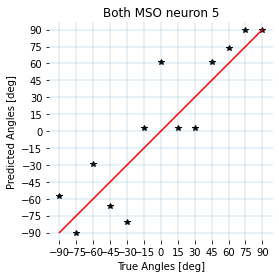

MSE: nan deg


ValueError: array must not contain infs or NaNs

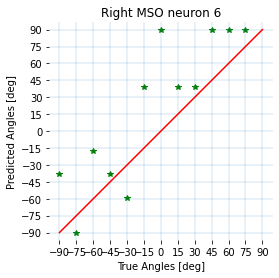

In [24]:
actors = np.append(["Right LSO", "Left LSO", "Both LSO"], np.tile(["Right MSO", "Left MSO", "Both MSO"],7).tolist())
r_pearson = np.zeros(25)

for j in range(25):
    if(j%3==0):
        c = 'g'
    if(j%3==1):
        c = 'm'
    if(j%3==2):
        c = 'k'
    fig, ax = plt.subplots(1,1, figsize = (4,4))
    y = np.zeros(len(angles))
    plt.xticks(ticks = angles)
    plt.yticks(ticks = angles)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    for i in range(len(angles)):
        angle = angles[i]
        y[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))[j]
    plt.plot(angles, y, '*', color = c)
    for i in range(len(angles)):
        plt.axvline(angles[i], linewidth = 0.2)
        plt.axhline(angles[i], linewidth = 0.2)
    plt.plot(angles, angles, color = 'r')
    plt.xlabel("True Angles [deg]")
    plt.ylabel("Predicted Angles [deg]")
    if(j<3):
        plt.title(actors[j])
    else:
        plt.title("{} neuron {}".format(actors[j], int(j/3)))
    errors = np.subtract(angles,y)
    mse = np.square(errors).mean()
    plt.axis('equal')
    #print("Errors", errors)
    print("MSE:", round(mse,3), "deg")
    r_pearson[j] = stats.pearsonr(angles, y)[0]
    print("R_pearson:", round(r_pearson[0],3))
    print("p_value:", r_pearson[1])
    plt.show()

# 1 LSO CONTROLATERAL

RMSE: 11.527 deg
R_pearson: 0.979
p_value: 5.890728419814439e-09


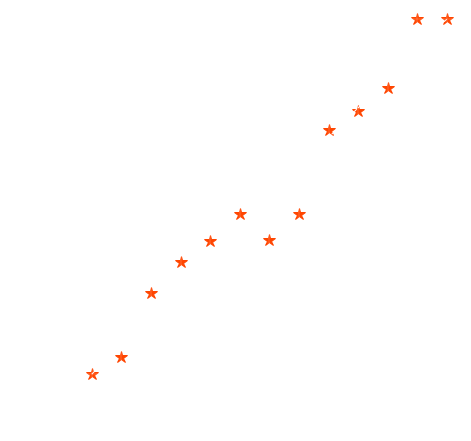

In [8]:

from matplotlib import rcParams 
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title


data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    dominant = data[i, 24]
    
    if dominant:
        lso_contro = data[i, 1]
    else:
        lso_contro = data[i, 0]
        
    y_pred[i] = lso_contro
    
    
fig, ax = plt.subplots(1, figsize=(7,7))
ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))
ax.plot(angles, y_pred, '*', color = 'orangered',  markersize = 12)


ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])

ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
plt.savefig('demo.png', transparent=True)
fig.show()


# 2 LSO BOTH

RMSE: 19.297 deg
R_pearson: 0.947
p_value: 9.578870561368014e-07


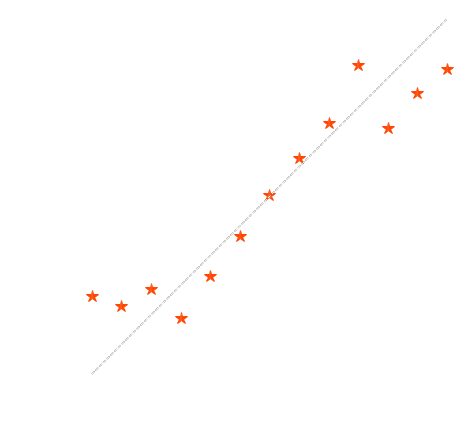

In [10]:


data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
        
    y_pred[i] = data[i][2]
    
    

fig, ax = plt.subplots(1, figsize=(7,7))
from matplotlib import rcParams 
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))
ax.plot(angles, y_pred, '*', color = 'orangered',  markersize = 12)

ax.plot(angles, angles, color = 'k', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
plt.savefig('demo.png', transparent=True)
fig.show()

# 3 LSO BINARY

RMSE: 50.269 deg
R_pearson: 0.866
p_value: 0.00012940169548043964


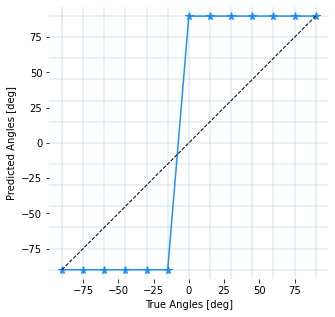

In [53]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
        
    dominant = data[i, 24]
    
    if dominant:
        lso_contro = +90
    else:
        lso_contro = -90
        
    y_pred[i] = lso_contro
    

fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(angles, y_pred, '*-', color = 'orangered',  markersize = 8)
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2)
    ax.axhline(angles[i], linewidth = 0.2)
ax.plot(angles, angles, color = 'k', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
fig.show()

# 4 MSO CONTRO

RMSE: 18.072 deg
R_pearson: 0.961
p_value: 1.695017138923087e-07


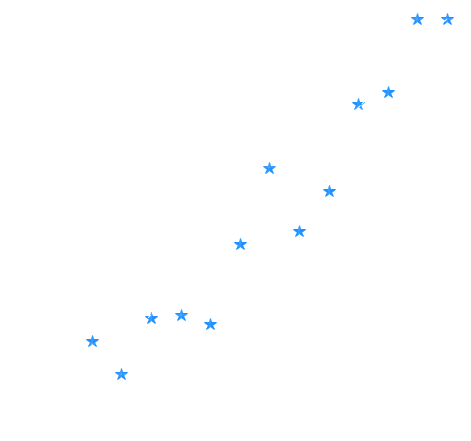

In [13]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    dominant = data[i, 24]
    
    if dominant:
        mso_contro = (data[i, 4] + data[i, 7] + data[i, 10] + data[i, 13] + data[i, 16])/5
    else:
        mso_contro = (data[i, 3] + data[i, 6] + data[i, 9] + data[i, 12] + data[i, 15])/5
        
    y_pred[i] = mso_contro
    
    
fig, ax = plt.subplots(1, figsize=(7,7))

ax.plot(angles, y_pred, '*', color = 'dodgerblue', markersize = 12)
from matplotlib import rcParams 
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))

ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
plt.savefig('demo.png', transparent=True)
fig.show()

# 5 MSO BOTH

RMSE: 21.397 deg
R_pearson: 0.948
p_value: 8.781733435034578e-07


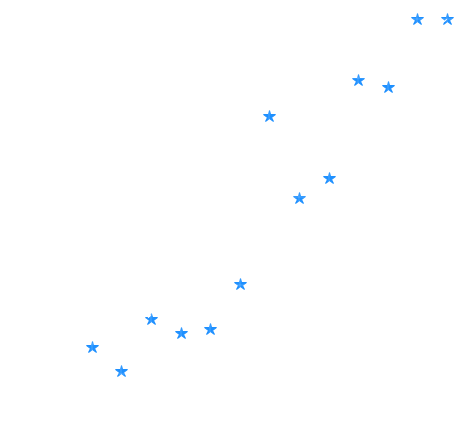

In [14]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    mso_contro = (data[i, 5] + data[i, 8] + data[i, 11] + data[i, 14] + data[i, 17])/5
 
    y_pred[i] = mso_contro
    
    
fig, ax = plt.subplots(1, figsize=(7,7))

ax.plot(angles, y_pred, '*', color = 'dodgerblue', markersize = 12)
from matplotlib import rcParams 
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))

ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
fig.show()
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
plt.savefig('demo.png', transparent=True)

# 6 LSO BOTH +  MSO BOTH

RMSE: 15.777 deg
R_pearson: 0.961
p_value: 1.844355771815892e-07


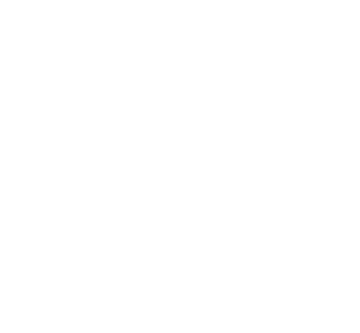

In [17]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    l_mso_contro = (data[i, 2] + (data[i, 5] + data[i, 8] + data[i, 11] + data[i, 14] + data[i, 17])/5)/2
 
    y_pred[i] = l_mso_contro
    
    
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(angles, y_pred, '*', color = 'w', markersize = 8)

ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')

ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))
plt.savefig('demo.png', transparent=True)
fig.show()


# 7 LSO CONTRO +  MSO CONTRO

RMSE: 11.06 deg
R_pearson: 0.983
p_value: 1.6575171794628716e-09


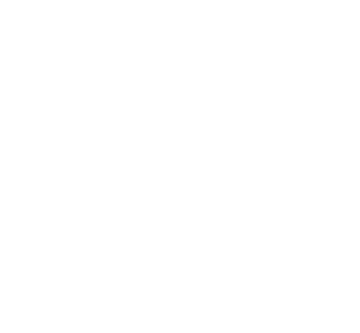

In [19]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    dominant = data[i, 24]
    
    if dominant:
        mso_contro = (data[i, 4] + data[i, 7] + data[i, 10] + data[i, 13] + data[i, 16])/5
        lso_contro = data[i, 1]
    else:
        mso_contro = (data[i, 3] + data[i, 6] + data[i, 9] + data[i, 12] + data[i, 15])/5
        lso_contro = data[i, 0]
        
    l_mso_contro = (mso_contro + lso_contro)/2
    y_pred[i] = l_mso_contro
    
    
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(angles, y_pred, '*', color = 'w', markersize = 8)

ax.plot(angles, angles, color = 'w', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2, color = 'w')
    ax.axhline(angles[i], linewidth = 0.2, color = 'w')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')

ax.set_xticks(np.arange(-90,120,30))
ax.set_yticks(np.arange(-90,120,30))
plt.savefig('demo.png', transparent=True)
fig.show()

# 8 LSO CONTRO +  MSO CONTRO (weighted sum)

RMSE: 7.593 deg
R_pearson: 0.992
p_value: 2.7103437326083786e-11


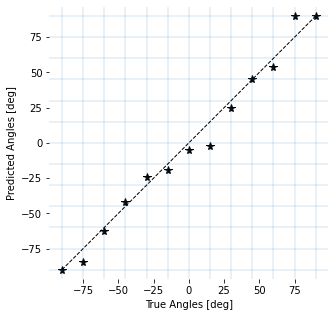

In [56]:
data = np.zeros([len(angles), 26])
y_pred = np.zeros(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    data[i] = np.loadtxt('results_4/results_angle_{}'.format(angle))
    
    dominant = data[i, 24]
    
    if dominant:
        mso_contro = data[i, 4]
        lso_contro = data[i, 1]
    else:
        mso_contro = data[i, 3]
        lso_contro = data[i, 0]
        
    l_mso_contro = (mso_contro + lso_contro*2)/3
    y_pred[i] = l_mso_contro
    
    
fig, ax = plt.subplots(1, figsize=(5,5))
ax.plot(angles, y_pred, '*', color = 'k', markersize = 8)
for i in range(len(angles)):
    ax.axvline(angles[i], linewidth = 0.2)
    ax.axhline(angles[i], linewidth = 0.2)
ax.plot(angles, angles, color = 'k', linestyle = 'dashed', linewidth = 1)
ax.set_xlabel("True Angles [deg]")
ax.set_ylabel("Predicted Angles [deg]")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
errors = np.subtract(angles, y_pred)
rmse = np.sqrt(np.square(errors).mean())
ax.axis('equal')
#print("Errors", errors)
print("RMSE:", round(rmse,3), "deg")
r_pearson = stats.pearsonr(angles, y_pred)
print("R_pearson:", round(r_pearson[0],3))
print("p_value:", r_pearson[1])
fig.show()